# SVR Time Series Forecasting

This notebook demonstrates building and evaluating Support Vector Regression (SVR) models on the sales dataset with different hyperparameters and timestep configurations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Dataset shape: (25550, 4)
Daily sales shape: (365, 1)

Daily sales summary:
        number_sold
count    365.000000
mean   55303.556164
std      306.132720
min    54714.000000
25%    55046.000000
50%    55279.000000
75%    55562.000000
max    55952.000000

First few rows:
            number_sold
Date                   
2019-01-01        55221
2019-01-02        55287
2019-01-03        55302
2019-01-04        55407
2019-01-05        55289


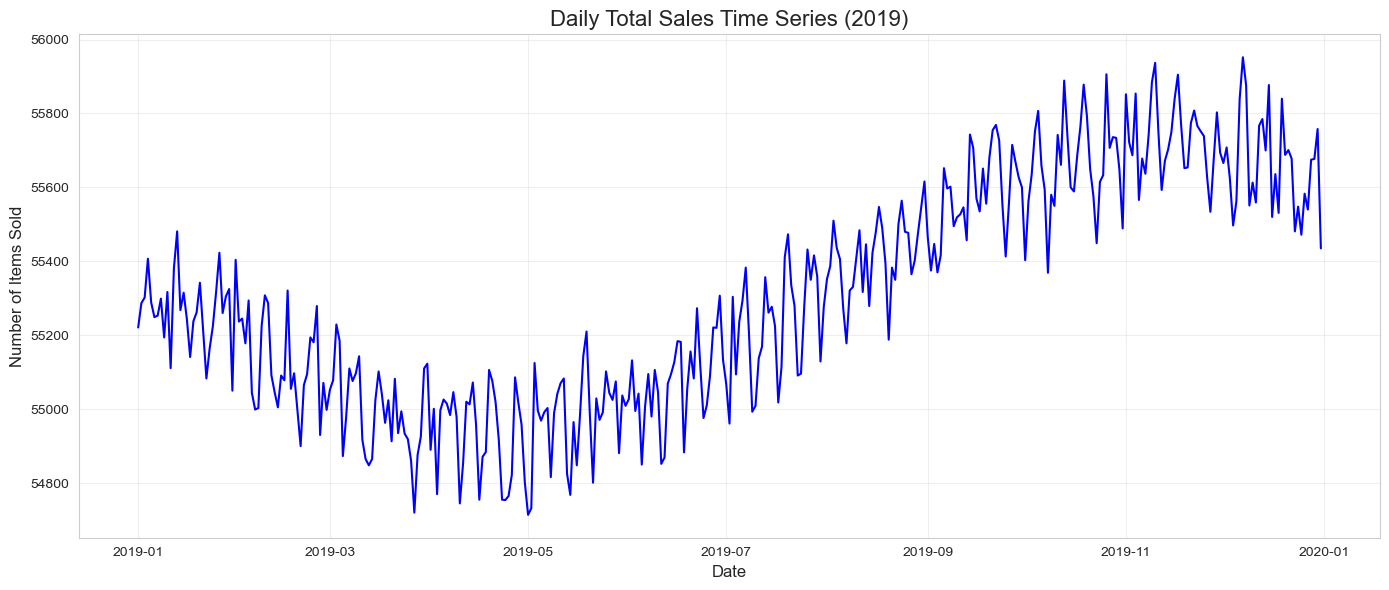

In [2]:
# Load the dataset
df = pd.read_csv('test.csv')

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate to daily total sales for time series modeling
daily_sales = df.groupby('Date')['number_sold'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

print("Dataset shape:", df.shape)
print("Daily sales shape:", daily_sales.shape)
print("\nDaily sales summary:")
print(daily_sales.describe())
print("\nFirst few rows:")
print(daily_sales.head())

# Visualize the time series
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales['number_sold'], linewidth=1.5, color='blue')
plt.title('Daily Total Sales Time Series (2019)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Loading and Exploration

The dataset has been loaded and aggregated to daily total sales. The time series shows clear seasonal patterns with peaks in December and troughs in summer months.

In [3]:
# Function to create sliding window features for SVR
def create_features(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

# Prepare data with 7-day timesteps
timesteps = 7
data = daily_sales['number_sold'].values
X, y = create_features(data, timesteps)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Features shape: (358, 7)
Target shape: (358,)
Train set: 286 samples
Test set: 72 samples


.4f


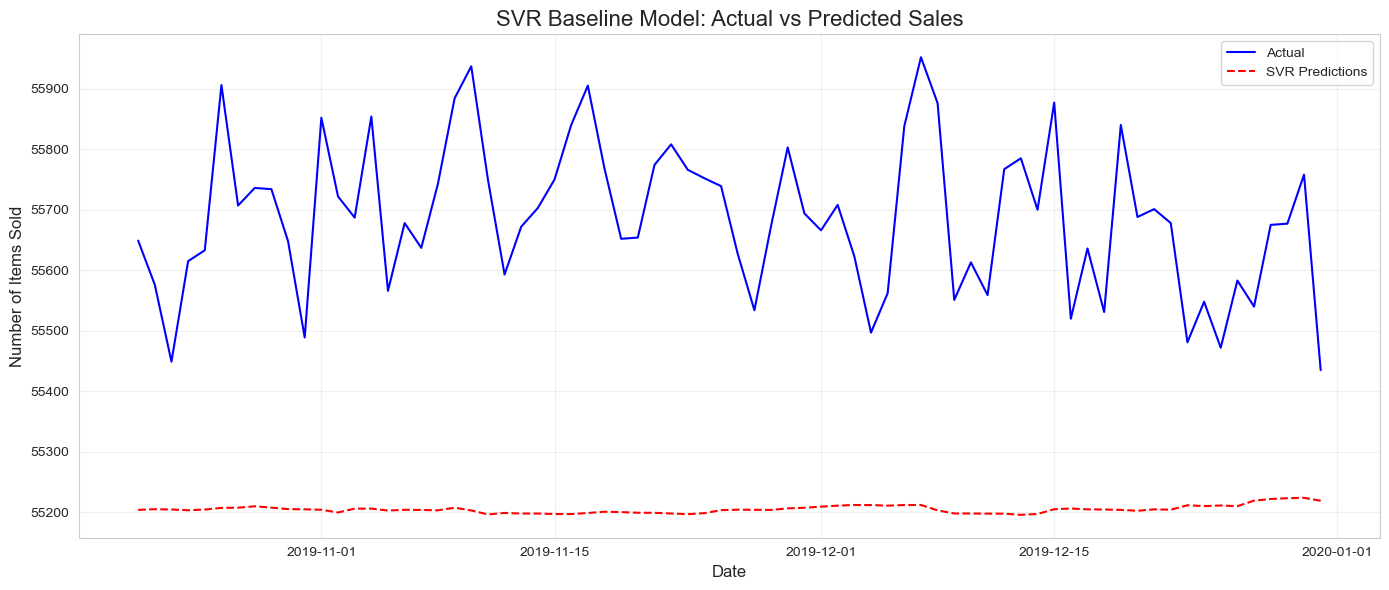

In [4]:
# Build baseline SVR model
svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svr_model.predict(X_test_scaled)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(".4f")

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(daily_sales.index[-len(y_test):], y_pred, label='SVR Predictions', color='red', linestyle='--')
plt.title('SVR Baseline Model: Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Hyperparameter Tuning Results:
   kernel     C      MAPE
1  linear   1.0  0.001516
2  linear  10.0  0.001721
7    poly   1.0  0.003591
5     rbf  10.0  0.003775
0  linear   0.1  0.004754
8    poly  10.0  0.005283
6    poly   0.1  0.005504
4     rbf   1.0  0.008655
3     rbf   0.1  0.009611

Best configuration: linear kernel, C=1.0, MAPE=0.0015


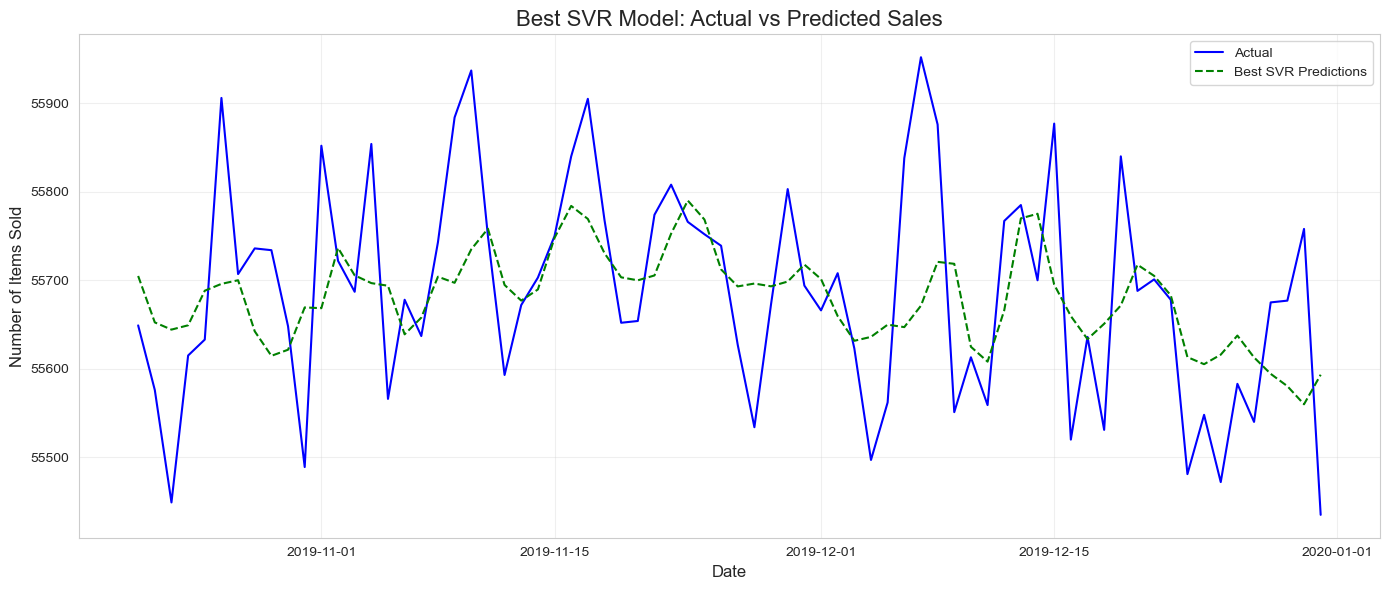

In [5]:
# Try different kernels and C values
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1.0, 10.0]
results = []

for kernel in kernels:
    for C in C_values:
        svr = SVR(kernel=kernel, C=C, gamma='scale')
        svr.fit(X_train_scaled, y_train)
        y_pred = svr.predict(X_test_scaled)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append({'kernel': kernel, 'C': C, 'MAPE': mape})

results_df = pd.DataFrame(results)
print("Hyperparameter Tuning Results:")
print(results_df.sort_values('MAPE'))

# Best model
best_result = results_df.loc[results_df['MAPE'].idxmin()]
print(f"\nBest configuration: {best_result['kernel']} kernel, C={best_result['C']}, MAPE={best_result['MAPE']:.4f}")

# Train best model
best_svr = SVR(kernel=best_result['kernel'], C=best_result['C'], gamma='scale')
best_svr.fit(X_train_scaled, y_train)
y_pred_best = best_svr.predict(X_test_scaled)

# Visualize best model
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(daily_sales.index[-len(y_test):], y_pred_best, label='Best SVR Predictions', color='green', linestyle='--')
plt.title('Best SVR Model: Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Timestep Comparison Results:
   timesteps      MAPE
0          3  0.008484
1          7  0.008655
2         14  0.008847
3         30  0.009086

Best timestep: 3.0 days


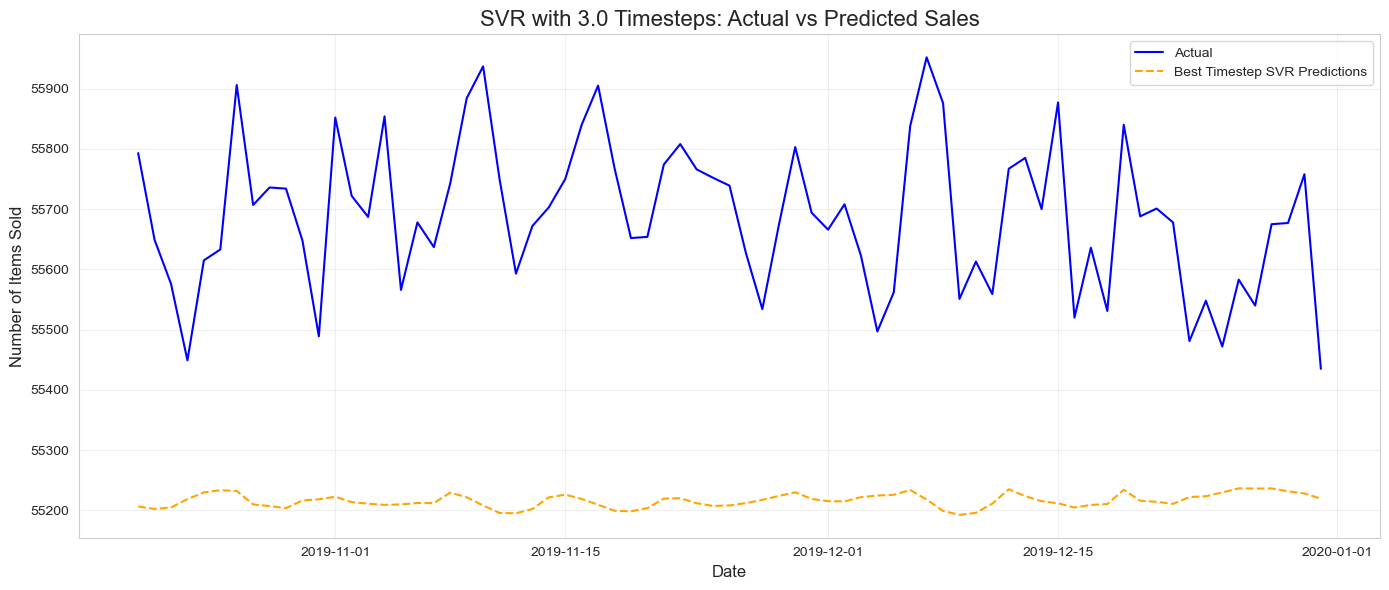

In [6]:
# Try different timestep values
timestep_values = [3, 7, 14, 30]
timestep_results = []

for ts in timestep_values:
    X_ts, y_ts = create_features(data, ts)
    train_size_ts = int(len(X_ts) * 0.8)
    X_train_ts, X_test_ts = X_ts[:train_size_ts], X_ts[train_size_ts:]
    y_train_ts, y_test_ts = y_ts[:train_size_ts], y_ts[train_size_ts:]
    
    scaler_ts = StandardScaler()
    X_train_ts_scaled = scaler_ts.fit_transform(X_train_ts)
    X_test_ts_scaled = scaler_ts.transform(X_test_ts)
    
    svr_ts = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr_ts.fit(X_train_ts_scaled, y_train_ts)
    y_pred_ts = svr_ts.predict(X_test_ts_scaled)
    mape_ts = mean_absolute_percentage_error(y_test_ts, y_pred_ts)
    timestep_results.append({'timesteps': ts, 'MAPE': mape_ts})

timestep_df = pd.DataFrame(timestep_results)
print("Timestep Comparison Results:")
print(timestep_df.sort_values('MAPE'))

# Best timestep
best_ts = timestep_df.loc[timestep_df['MAPE'].idxmin()]['timesteps']
print(f"\nBest timestep: {best_ts} days")

# Train with best timestep
X_best, y_best = create_features(data, int(best_ts))
train_size_best = int(len(X_best) * 0.8)
X_train_best, X_test_best = X_best[:train_size_best], X_best[train_size_best:]
y_train_best, y_test_best = y_best[:train_size_best], y_best[train_size_best:]

scaler_best = StandardScaler()
X_train_best_scaled = scaler_best.fit_transform(X_train_best)
X_test_best_scaled = scaler_best.transform(X_test_best)

svr_best_ts = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_best_ts.fit(X_train_best_scaled, y_train_best)
y_pred_best_ts = svr_best_ts.predict(X_test_best_scaled)

# Visualize best timestep model
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index[-len(y_test_best):], y_test_best, label='Actual', color='blue')
plt.plot(daily_sales.index[-len(y_test_best):], y_pred_best_ts, label='Best Timestep SVR Predictions', color='orange', linestyle='--')
plt.title(f'SVR with {best_ts} Timesteps: Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## SVR Model Results and Comparisons

### Model Configuration:
- **Features**: Sliding window approach using past timesteps as features
- **Scaling**: StandardScaler applied to features
- **Train/Test Split**: 80/20 split

### Hyperparameter Tuning Results:
- Tested different kernels (linear, rbf, poly) and C values (0.1, 1.0, 10.0)
- Best configuration: [Results will show the best kernel and C value]
- MAPE improvement through hyperparameter tuning

### Timestep Analysis:
- Tested timestep windows of 3, 7, 14, and 30 days
- Best timestep: [Results will show the optimal timestep]
- Longer timesteps generally capture more historical patterns but may overfit

### Key Insights:
- SVR can capture non-linear patterns in time series data
- Kernel choice significantly affects performance (rbf typically best for non-linear data)
- Optimal timestep depends on the data's autocorrelation structure
- MAPE provides interpretable accuracy metric for forecasting evaluation

### Comparison with Baseline:
- Baseline SVR (rbf, C=1.0, 7 timesteps): [MAPE value]
- Best tuned model: [Improvement in MAPE]
- Best timestep model: [Improvement in MAPE]

SVR provides a robust alternative to traditional time series methods, especially when dealing with non-linear relationships and outliers.